In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opencv-python
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1) Thực hiện việc rút gọn số chiều dữ liệu, hiển thị trực quan các phân lớp dữ liệu dạng 3D hoặc 2D.

In [ ]:
# Import các thư viện cần thiết
from __future__ import print_function
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from matplotlib import pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA as sklearnPCA
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2
from sklearn.metrics import classification_report
from skimage import feature
from sklearn.linear_model import LogisticRegression

# Định nghĩa các đường dẫn đến các thư mục chứa dữ liệu ảnh
base_dir = '/content/drive/Shareddrives/Project ML/animals_data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
train_goats_dir = os.path.join(train_dir, 'goats')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
validation_goats_dir = os.path.join(validation_dir, 'goats')

# Định nghĩa kích thước mong muốn của ảnh
target_size = (150, 150)

In [ ]:


# Định nghĩa các hàm để đọc và xử lý ảnh
def read_image(path):
    # Đọc ảnh từ đường dẫn
    image = cv2.imread(path)
    # Thay đổi kích thước ảnh
    image = cv2.resize(image, target_size)
    # Chuyển ảnh thành mảng numpy
    image = np.reshape(image, 150 ** 2 * 3)
    # Chuẩn hóa giá trị điểm ảnh về khoảng [0, 1]
    image = image / 255.0
    return image


def read_images(dir):
    # Tạo một danh sách rỗng để lưu trữ các mảng ảnh
    images = []
    # Duyệt qua các tập tin trong thư mục
    for file in os.listdir(dir):
        # Nếu tập tin là ảnh jpg hoặc jpeg
        if file.endswith('.jpg') or file.endswith('.jpeg'):
            # Đọc và xử lý ảnh
            image = read_image(os.path.join(dir, file))
            # Thêm mảng ảnh vào danh sách
            images.append(image)
    # Chuyển danh sách thành một mảng numpy
    images = np.array(images)
    return images


# Đọc và xử lý các ảnh trong tập huấn luyện và kiểm tra
X_train_cat = read_images(train_cats_dir)
X_train_dog = read_images(train_dogs_dir)
X_train_goat = read_images(train_goats_dir)
X_val_cat = read_images(validation_cats_dir)
X_val_dog = read_images(validation_dogs_dir)
X_val_goat = read_images(validation_goats_dir)

# Tạo nhãn cho các loài động vật: mèo là 0, chó là 1 và cừu là 2
y_train_cat = np.zeros(len(X_train_cat))
y_train_dog = np.ones(len(X_train_dog))
y_train_goat = np.full(len(X_train_goat), 2)
y_val_cat = np.zeros(len(X_val_cat))
y_val_dog = np.ones(len(X_val_dog))
y_val_goat = np.full(len(X_val_goat), 2)
# Nối các mảng ảnh và nhãn lại thành một tập dữ liệu duy nhất cho tập huấn luyện và kiểm tra
X_train = np.concatenate((X_train_cat, X_train_dog, X_train_goat), axis=0)
print(X_train)
y_train = np.concatenate((y_train_cat, y_train_dog, y_train_goat), axis=0)
print(y_train)
X_val = np.concatenate((X_val_cat, X_val_dog, X_val_goat), axis=0)
y_val = np.concatenate((y_val_cat, y_val_dog, y_val_goat), axis=0)

# Xáo trộn thứ tự của các mẫu trong tập huấn luyện
perm = np.random.permutation(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]

X_train_lib = X_train
y_train_lib = y_train
print(X_train.shape)

[[0.68627451 0.68235294 0.66666667 ... 0.47058824 0.51764706 0.47058824]
 [0.94901961 0.91764706 0.94509804 ... 0.86666667 0.89803922 0.9254902 ]
 [0.49803922 0.52156863 0.52156863 ... 0.         0.33333333 0.44313725]
 ...
 [0.54509804 0.49803922 0.40392157 ... 0.         0.00784314 0.00784314]
 [0.1254902  0.47058824 0.37647059 ... 0.14117647 0.30196078 0.25490196]
 [0.2745098  0.55294118 0.48235294 ... 0.31372549 0.59607843 0.55686275]]
[0. 0. 0. ... 2. 2. 2.]
(3000, 67500)


## Rút gọn số chiều dữ liệu

In [ ]:
new_data = np.concatenate((X_train, X_val), axis=0)
new_label = np.concatenate((y_train, y_val), axis=0)

## Phân lớp dữ liệu dạng 2D

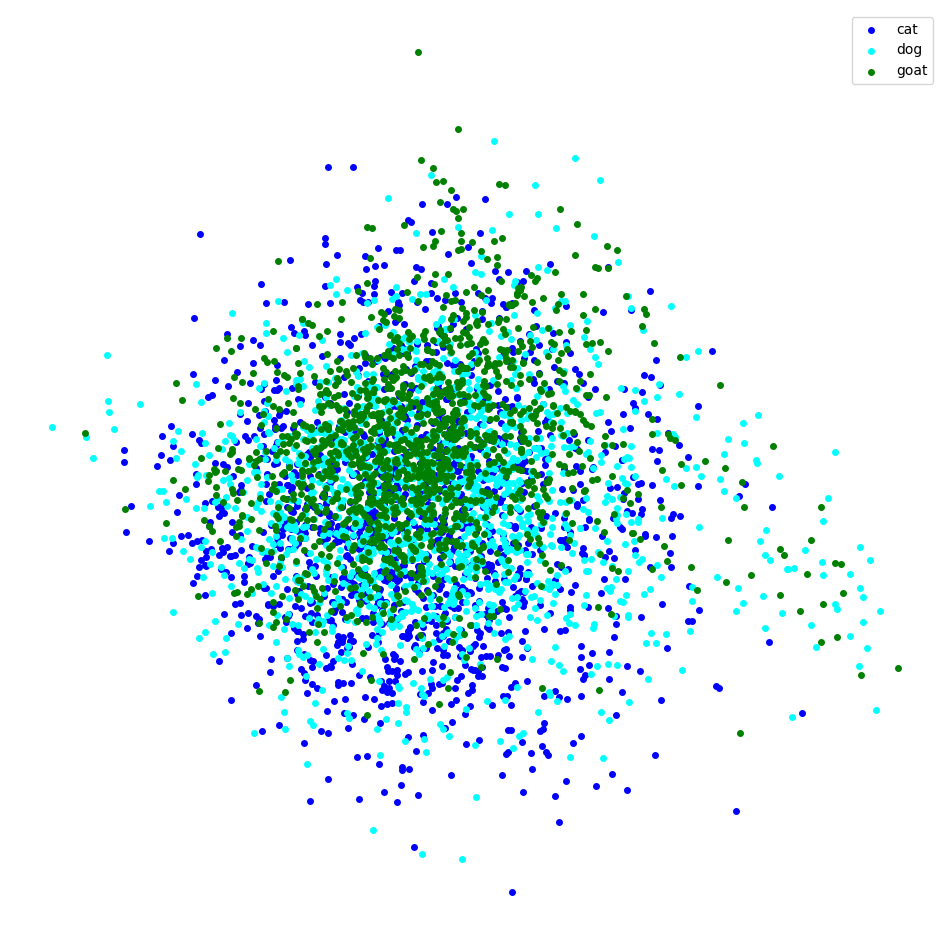

In [ ]:
pca = sklearnPCA(n_components=2)
X_2D = pca.fit_transform(new_data)
scaler = StandardScaler()
X_2D = scaler.fit_transform(X_2D)

colors = ['blue', 'cyan', 'green']
animal = ['cat', 'dog', 'goat']
plt.figure(figsize=(12, 12))
for i in range(3):
    plt.scatter(X_2D[new_label == i, 0], X_2D[new_label == i, 1], s=16, label=f'{animal[i]}', c=colors[i])
plt.axis('off')
plt.legend()
plt.show()

## Phân lớp dữ liệu dạng 3D

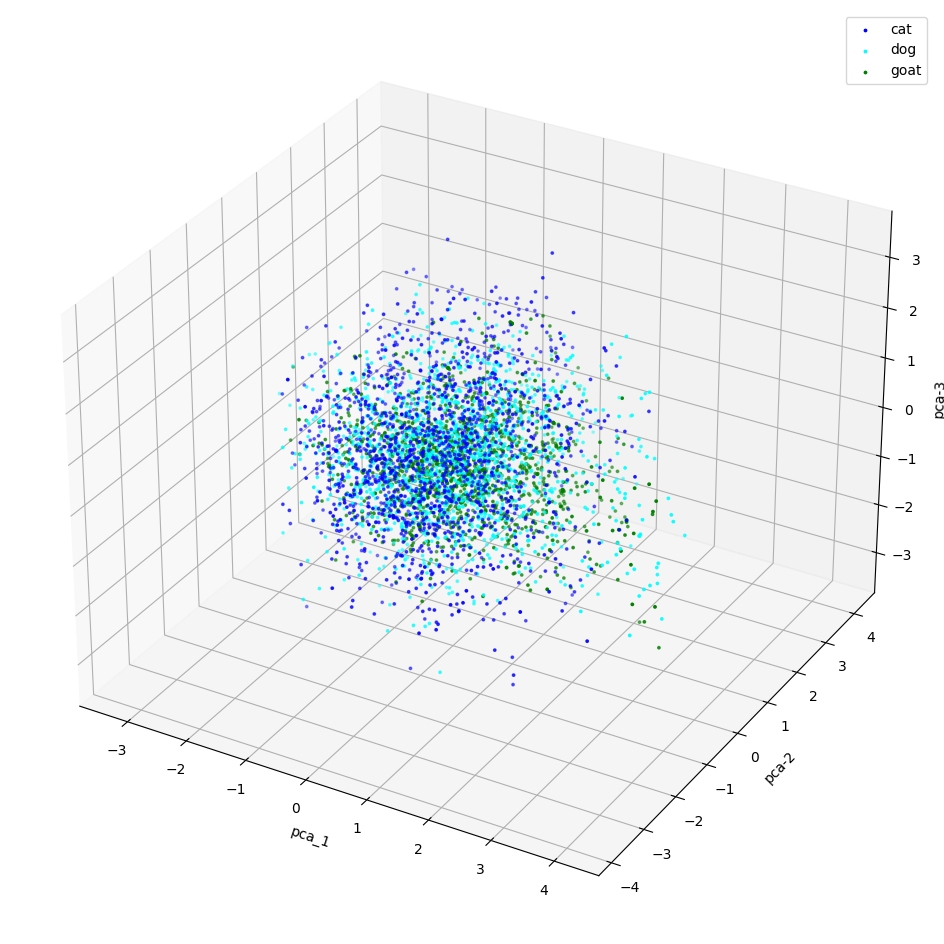

In [ ]:
pca = sklearnPCA(n_components=3)
X_3D = pca.fit_transform(new_data)
scaler = StandardScaler()
X_3D = scaler.fit_transform(X_3D)

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
for i in range(3):
    plt_3d = ax.scatter3D(X_3D[new_label == i, 0], X_3D[new_label == i, 1], X_3D[new_label == i, 2], c=colors[i], s=3,
                          label=f'{animal[i]}')
ax.set_xlabel('pca_1')
ax.set_ylabel('pca-2')
ax.set_zlabel('pca-3')
plt.legend()
plt.show()

# 2) Phân Cụm

In [ ]:
# Gọi các thư viện cần thiết
# Ta tự xây dựng phần k-means nên sẽ không gọi sklearn
from matplotlib import markers


def kmeans_display(X, label, centers):
    K = np.amax(label) + 1
    plt.figure(figsize=(12, 12))
    colors = ['blue', 'cyan', 'green', 'red', 'yellow', 'orange']

    plt.figure(figsize=(12, 12))
    for i in range(3):
        X0 = X[label == i, :]
        plt.scatter(X0[:, 0], X0[:, 1], s=16, c=colors[i])
        plt.plot(centers[i][0], centers[i][1], c=colors[i + 3], marker='*', markersize=20)  # Vẽ tâm cụm i lên đồ thị
    plt.axis('equal')
    plt.plot()
    plt.show()

In [ ]:
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]


def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis=1)

In [ ]:
def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k, :] = np.mean(Xk, axis=0)
    return centers

In [ ]:
def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

In [ ]:
def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

Centers found by our algorithm:
[[-0.81935366 -0.38726023]
 [ 1.01536385 -0.76909778]
 [ 0.19545856  0.95862402]]


<Figure size 1200x1200 with 0 Axes>

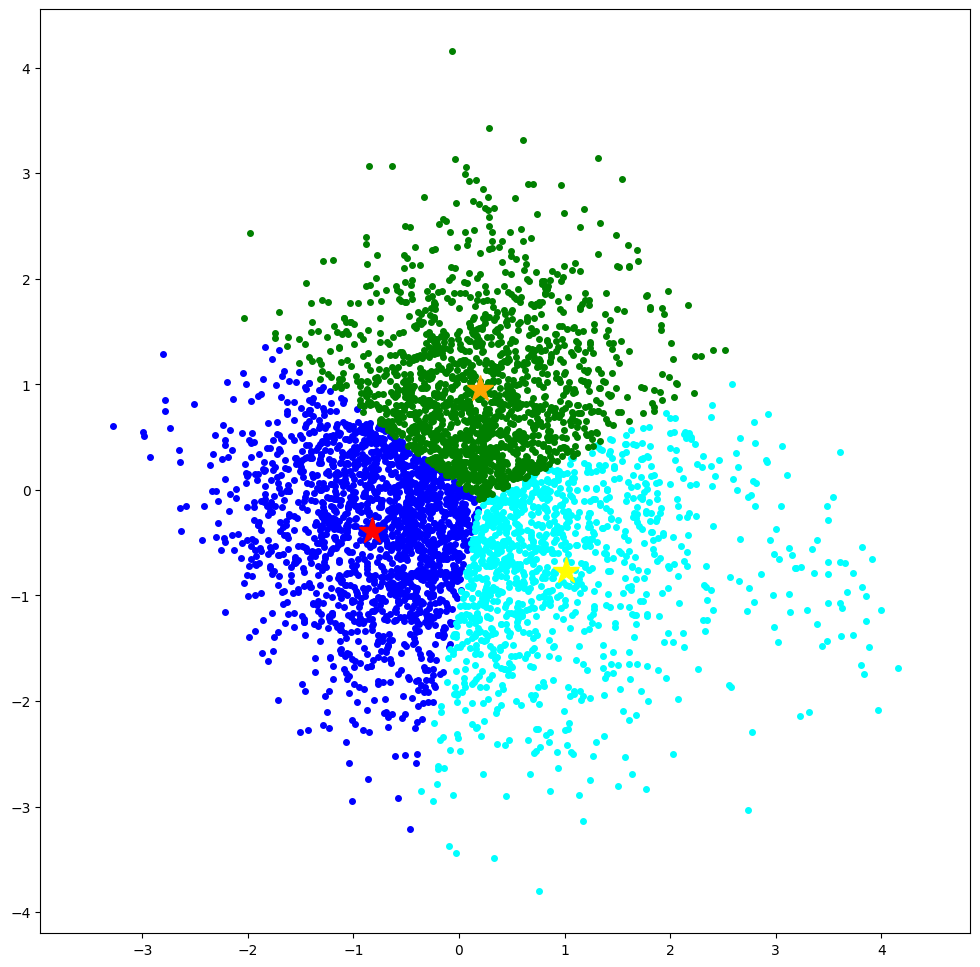

In [ ]:
(centers, labels, it) = kmeans(X_2D, 3)
print('Centers found by our algorithm:')
print(centers[-1])
init_centers = kmeans_update_centers(X_2D, labels[-1], 3)
kmeans_display(X_2D, labels[-1], init_centers)

##Sử dụng thư viện

Centers found by scikit-learn:
[[-0.81676143 -0.40778059]
 [ 1.03036531 -0.75233292]
 [ 0.17858633  0.95388598]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Figure size 1200x1200 with 0 Axes>

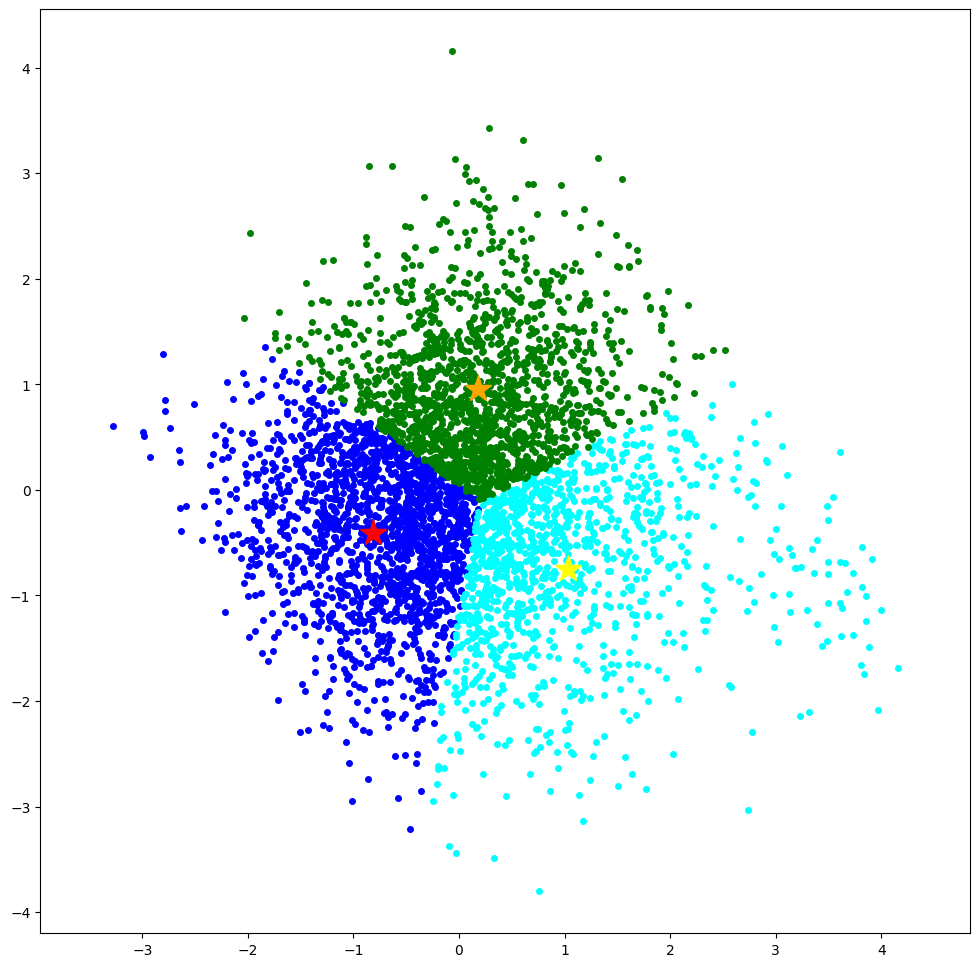

In [ ]:
tv_kmeans = KMeans(n_clusters=3, random_state=0).fit(X_2D)

print('Centers found by scikit-learn:')
print(tv_kmeans.cluster_centers_)
# Xác suất thuộc loại nào
pred_label = tv_kmeans.predict(X_2D)
# Vẽ bảng phân cụm
plt.figure(figsize=(12, 12))
colors = ['blue', 'cyan', 'green', 'red', 'yellow', 'orange']

plt.figure(figsize=(12, 12))
for i in range(3):
    X0 = X_2D[pred_label == i, :]
    plt.scatter(X0[:, 0], X0[:, 1], s=16, c=colors[i])
    plt.plot(tv_kmeans.cluster_centers_[i][0], tv_kmeans.cluster_centers_[i][1], c=colors[i + 3], marker='*',
             markersize=20)  # Vẽ tâm cụm i lên đồ thị
plt.axis('equal')
plt.plot()
plt.show()

# 3) Xây dựng chương trình sử dụng mô hình Multinomial Logistic Regression (Softmax)


In [ ]:
# Định nghĩa các đường dẫn đến các thư mục chứa dữ liệu ảnh
base_dir = '/content/drive/Shareddrives/Project ML/animals_data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
train_goats_dir = os.path.join(train_dir, 'goats')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
validation_goats_dir = os.path.join(validation_dir, 'goats')

# Định nghĩa kích thước mong muốn của ảnh
target_size = (150, 150)

In [ ]:
# Định nghĩa các hàm để đọc và xử lý ảnh
def read_image(path):
    image = cv2.imread(path)
    # Resize ảnh về kích thước 64x128 và chuyển sang xám
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Tính gradient cho ảnh bằng cách áp dụng các toán tử lấy đạo hàm theo hai hướng Ox và Oy
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0)  # Gradient theo hướng x
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1)  # Gradient theo hướng y
    # Tính cường độ và hướng của gradient
    mag = np.sqrt(gx ** 2 + gy ** 2)
    ang = np.arctan2(gy, gx) * (180 / np.pi) % 180
    # Tính vector đặc trưng HOG cho từng ô (cell), chuẩn hóa khối (block) và tính toán vector HOG cho ảnh
    hog = feature.hog(mag, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True,
                      block_norm='L1', visualize=False)
    # Trả về vector HOG của ảnh
    return hog


def read_images(dir):
    # Tạo một danh sách rỗng để lưu trữ các mảng ảnh
    images = []
    # Duyệt qua các tập tin trong thư mục
    for file in os.listdir(dir):
        # Nếu tập tin là ảnh jpg hoặc png
        if file.endswith('.jpg') or file.endswith('.jpeg'):
            # Đọc và xử lý ảnh
            image = read_image(os.path.join(dir, file))
            # Thêm mảng ảnh vào danh sách
            images.append(image)
    # Chuyển danh sách thành một mảng numpy
    images = np.array(images)
    return images


# Đọc và xử lý các ảnh trong tập huấn luyện và kiểm tra
X_train_cat = read_images(train_cats_dir)
X_train_dog = read_images(train_dogs_dir)
X_train_goat = read_images(train_goats_dir)
X_val_cat = read_images(validation_cats_dir)
X_val_dog = read_images(validation_dogs_dir)
X_val_goat = read_images(validation_goats_dir)

# Tạo nhãn cho các loài động vật: mèo là 0, chó là 1 và dê là 2
y_train_cat = np.zeros(len(X_train_cat))
y_train_dog = np.ones(len(X_train_dog))
y_train_goat = np.full(len(X_train_goat), 2)
y_val_cat = np.zeros(len(X_val_cat))
y_val_dog = np.ones(len(X_val_dog))
y_val_goat = np.full(len(X_val_goat), 2)
# Nối các mảng ảnh và nhãn lại thành một tập dữ liệu duy nhất cho tập huấn luyện và kiểm tra
X_train = np.concatenate((X_train_cat, X_train_dog, X_train_goat), axis=0)
y_train = np.concatenate((y_train_cat, y_train_dog, y_train_goat), axis=0)
X_val = np.concatenate((X_val_cat, X_val_dog, X_val_goat), axis=0)
y_val = np.concatenate((y_val_cat, y_val_dog, y_val_goat), axis=0)

# Xáo trộn thứ tự của các mẫu trong tập huấn luyện
perm = np.random.permutation(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]

X_train_lib = X_train
y_train_lib = y_train
X_train = np.asarray(X_train.squeeze())
print(X_train.shape)

(3000, 10404)


In [ ]:
# Convert matrix to image

def convert_labels(y, C):
    from scipy import sparse

    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape=(C, len(y))).toarray()
    return Y


def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis=0)
    return A


def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = e_Z / e_Z.sum(axis=0)
    return A


def pred(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis=0)


def _softmax_regression(X, Y, theta, lambda_=0.5, iterations=10, learning_rate=1e-5, batch_size=200):
    from sklearn.metrics import log_loss
    losses = []
    _theta = theta
    d, N = X.shape
    for iter_ in range(iterations):
        shuffle_index = np.random.permutation(N)

        for i in shuffle_index:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(3, 1)
            ai = softmax_stable(np.dot(_theta.T, xi))
            _theta += learning_rate * xi.dot((yi - ai).T)
            if (iter_ * N + i) % batch_size == 0:
                Y_hat = np.dot(_theta.T, X)
                losses.append(log_loss(Y, Y_hat))
        Y_hat = np.dot(_theta.T, X)
        print(f"epoch {iter_} - cost {log_loss(Y, Y_hat) / N}")
    return _theta, losses


import random
import matplotlib.pyplot as plt

X_train_Softmax = np.concatenate((np.ones((1, X_train.shape[0])), X_train.T), axis=0)

Y_train_Softmax = convert_labels(y_train, 3)
print(X_train_Softmax.shape)
print(Y_train_Softmax.shape)

(10405, 3000)
(3, 3000)


In [ ]:
from sklearn.metrics import confusion_matrix

model = LogisticRegression(multi_class="multinomial", solver="lbfgs")

model.fit(X_train_lib, y_train_lib)
y_pred = model.predict(X_val)  # Dự đoán nhãn cho các mẫu trong tập kiểm tra


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 4) Multiclasses_SVM

In [ ]:
# method to compute loss function and its gradient
# here vectorization was used to speed up
def svm_loss_vectorized(W, X, y, reg):
    d, C = W.shape
    _, N = X.shape
    loss = 0
    dW = np.zeros_like(W)
    Z = W.T.dot(X)
    correct_class_score = np.choose(y, Z).reshape(N, 1).T
    margins = np.maximum(0, Z - correct_class_score + 1)
    margins[y, np.arange(margins.shape[1])] = 0
    # Loss function
    loss = np.sum(margins, axis=(0, 1))
    loss /= N
    loss += 0.5 * reg * np.sum(W * W)
    F = (margins > 0).astype(int)
    F[y, np.arange(F.shape[1])] = np.sum(-F, axis=0)
    # Gradient
    dW = X.dot(F.T) / N + reg * W
    return loss, dW

In [ ]:
# Mini-batch gradient descent
def multiclass_svm_GD(X, y, Winit, reg, lr=.1, \
                      batch_size=100, num_iters=1000, print_every=100):
    W = Winit
    loss_history = np.zeros((num_iters))
    for it in range(num_iters):
        # randomly pick a batch of X
        idx = np.random.choice(X.shape[1], batch_size)
        X_batch = X[:, idx]
        y_batch = y[idx]

        loss_history[it], dW = svm_loss_vectorized(W, X_batch, y_batch, reg)
        W -= lr * dW
        if it % print_every == 1:
            print('it %d/%d, loss = %f' % (it, num_iters, loss_history[it]))
    return W, loss_history

# 5) So sánh độ chính xác (sử dụng accuracy, confusion matrix, recall và precision)


In [ ]:
# Tính toán các độ đo đánh giá
acc = accuracy_score(y_val, y_pred)  # Độ chính xác
pre = precision_score(y_val, y_pred, average='macro')  # Độ chính xác trung bình của các lớp
rec = recall_score(y_val, y_pred, average='macro')  # Độ bao phủ trung bình của các lớp
cf_matrix = confusion_matrix(y_val, y_pred)
# In ra các độ đo đánh giá
print('Confusion matrix:')
print(cf_matrix)
print('Accuracy:', acc)
print('Precision:', pre)
print('Recall:', rec)
print(classification_report(y_val, y_pred))

Confusion matrix:
[[299 101 100]
 [128 215 157]
 [ 63 112 325]]
Accuracy: 0.5593333333333333
Precision: 0.5569865914056794
Recall: 0.5593333333333333
              precision    recall  f1-score   support

         0.0       0.61      0.60      0.60       500
         1.0       0.50      0.43      0.46       500
         2.0       0.56      0.65      0.60       500

    accuracy                           0.56      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.56      0.56      0.56      1500



In [ ]:
from sklearn.metrics import confusion_matrix

# 3000, 10404
print(X_train.shape)
print(y_train.shape)
reg = .05
W = np.random.randn(10404, 3)
y_train_SVM = y_train.astype(int)

W, loss_history = multiclass_svm_GD(X_train.T, y_train_SVM, W, reg)

y_pred = np.array([np.argmax(a) for a in np.dot(W.T, X_val.T).T])
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


(3000, 10404)
(3000,)
it 1/1000, loss = 778.029443
it 101/1000, loss = 285.405374
it 201/1000, loss = 105.622651
it 301/1000, loss = 39.538638
it 401/1000, loss = 15.592331
it 501/1000, loss = 6.516928
it 601/1000, loss = 3.364733
it 701/1000, loss = 2.141603
it 801/1000, loss = 1.746585
it 901/1000, loss = 1.688024
[[229 144 127]
 [ 78 244 178]
 [ 35 119 346]]
              precision    recall  f1-score   support

         0.0       0.67      0.46      0.54       500
         1.0       0.48      0.49      0.48       500
         2.0       0.53      0.69      0.60       500

    accuracy                           0.55      1500
   macro avg       0.56      0.55      0.54      1500
weighted avg       0.56      0.55      0.54      1500



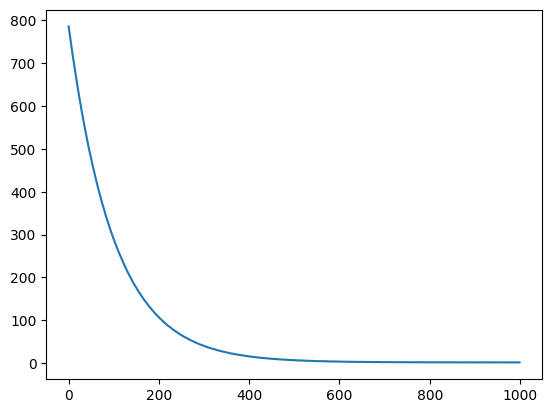

In [ ]:
import matplotlib.pyplot as plt

# plot loss as a function of iteration
plt.plot(loss_history)
plt.show()

# Tối ưu tham số cho mô hình MLR

In [ ]:
from skopt.callbacks import VerboseCallback

# Định nghĩa không gian tìm kiếm cho các siêu tham số
param_space = {
    'C': (1e-6, 1e+6, 'log-uniform'),  # Hệ số điều chuẩn (từ 1e-6 đến 1e+6, phân phối theo tỷ lệ logarithmic)
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Phương pháp giải quyết bài toán tối ưu
    'max_iter': (10, 1000),  # Số lượng epoch
}


# Định nghĩa hàm mục tiêu
def objective(params):
    model = LogisticRegression(**params)
    model.fit(X_train_lib, y_train_lib)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return -accuracy  # Đảo dấu vì Bayesian Optimization tìm kiếm giá trị lớn nhất


# Tạo bộ tối ưu hóa Bayesian
opt = BayesSearchCV(LogisticRegression(), param_space, n_iter=50, n_jobs=-1)

# Tiến hành tối ưu hóa
opt.fit(X_train_lib, y_train_lib)

# In ra siêu tham số tốt nhất và độ chính xác tương ứng
print("Best parameters found: ", opt.best_params_)
print("Best accuracy found: ", opt.best_score_)

In [ ]:
y_pred = opt.predict(X_val)
print(classification_report(y_val, y_pred))